In [1]:
import math, random, io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
device = "cuda:2"
IMG_SIZE = 32
EMBED_DIM = 64
BATCH_SIZE = 64
EPOCHS = 100
LR = 3e-4
TEMPERATURE = 0.07
ATTENTION_HEADS = 4

In [3]:
colors = [
    'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown',
    'black', 'white', 'gray', 'cyan', 'magenta', 'lime', 'maroon', 'navy',
    'teal', 'olive', 'gold', 'silver'
]

shapes = [
    'circle', 'square', 'triangle'
]

positions = [
    'top-left', 'top', 'top-right',
    'left', 'center', 'right',
    'bottom-left', 'bottom', 'bottom-right'
]

In [4]:
from PIL import Image, ImageDraw
import math

def draw_sample(color, shape, position, img_size=128):
    img = Image.new('RGB', (img_size, img_size), 'white')
    draw = ImageDraw.Draw(img)

    margin = 6
    w = h = img_size - 2 * margin
    half = w // 2

    # -----------------------------
    #   X COORDS
    # -----------------------------
    if "left" in position:
        x0 = margin
        x1 = margin + half
    elif 'top-left' in position:
        x0 = margin
        x1 = margin + half
    elif 'bottom-left' in position:
        x0 = margin
        x1 = margin + half
    elif "right" in position:
        x0 = margin + half
        x1 = margin + w
    elif 'top-right' in position:
        x0 = margin
        x1 = margin + half
    elif 'bottom-right' in position:
        x0 = margin
        x1 = margin + half
    else:  # center
        x0 = margin + w // 4
        x1 = margin + 3 * w // 4

    # -----------------------------
    #   Y COORDS
    # -----------------------------
    if "top" in position:
        y0 = margin
        y1 = margin + half
    elif "top-left" in position:
        y0 = margin
        y1 = margin + half
    elif "top-right" in position:
        y0 = margin
        y1 = margin + half
    elif "bottom" in position:
        y0 = margin + half
        y1 = margin + w
    elif "bottom-left" in position:
        y0 = margin
        y1 = margin + half
    elif "bottom-right" in position:
        y0 = margin
        y1 = margin + half
    else:  # center
        y0 = margin + w // 4
        y1 = margin + 3 * w // 4

    bbox = (x0, y0, x1, y1)
    cx = (x0 + x1) / 2   # center x
    cy = (y0 + y1) / 2   # center y
    rw = (x1 - x0) / 2   # radius w
    rh = (y1 - y0) / 2   # radius h

    # ===========================================================
    #                SHAPE DRAWING LOGIC
    # ===========================================================

    if shape == 'circle':
        draw.ellipse(bbox, fill=color, outline='black')

    elif shape == 'square':
        draw.rectangle(bbox, fill=color, outline='black')

    elif shape == 'triangle':
        draw.polygon([
            (cx, y0),
            (x0, y1),
            (x1, y1)
        ], fill=color, outline='black')

    return img


In [5]:
# ====================================================================
#            Helper Functions for Fancy Shapes
# ====================================================================

def draw_regular_polygon(draw, cx, cy, radius, n, color):
    points = []
    for i in range(n):
        angle = 2 * math.pi * i / n - math.pi / 2
        px = cx + radius * math.cos(angle)
        py = cy + radius * math.sin(angle)
        points.append((px, py))
    draw.polygon(points, fill=color, outline='black')


def draw_star(draw, cx, cy, radius, color):
    points = []
    for i in range(10):
        r = radius if i % 2 == 0 else radius / 2.5
        angle = math.pi/2 + i * (math.pi / 5)
        px = cx + r * math.cos(angle)
        py = cy - r * math.sin(angle)
        points.append((px, py))
    draw.polygon(points, fill=color, outline='black')


def draw_heart(draw, bbox, color):
    x0, y0, x1, y1 = bbox
    w = x1 - x0
    h = y1 - y0

    draw.polygon([
        (x0 + w*0.5, y1),
        (x0, y0 + h*0.4),
        (x0 + w*0.25, y0),
        (x0 + w*0.5, y0 + h*0.2),
        (x0 + w*0.75, y0),
        (x1, y0 + h*0.4),
    ], fill=color, outline='black')


def draw_cross(draw, bbox, color):
    x0, y0, x1, y1 = bbox
    w = (x1 - x0) / 3
    h = (y1 - y0) / 3
    draw.rectangle((x0 + w, y0, x0 + 2*w, y1), fill=color, outline='black')
    draw.rectangle((x0, y0 + h, x1, y0 + 2*h), fill=color, outline='black')


def draw_arrow(draw, bbox, color):
    x0, y0, x1, y1 = bbox
    mid = (x0 + x1) / 2
    draw.polygon([
        (mid, y0),
        (x1, y1),
        (mid, y1 * 0.9),
        (x0, y1),
    ], fill=color, outline='black')


def draw_moon(draw, bbox, color):
    x0, y0, x1, y1 = bbox
    draw.ellipse(bbox, fill=color)
    draw.ellipse((x0 + (x1-x0)*0.3, y0, x1, y1), fill="white", outline='black')


def draw_cloud(draw, bbox, color):
    x0, y0, x1, y1 = bbox
    w = x1 - x0
    h = y1 - y0
    draw.ellipse((x0, y0 + h*0.3, x0 + w*0.6, y1), fill=color, outline='black')
    draw.ellipse((x0 + w*0.4, y0, x1, y0 + h*0.7), fill=color, outline='black')
    draw.ellipse((x0 + w*0.2, y0 + h*0.2, x1 - w*0.2, y1), fill=color, outline='black')

In [6]:
class ShapesDataset(Dataset):

    def __init__(self):
        self.images = []
        self.captions = []

        for c in colors:
            for s in shapes:
                for p in positions:
                    img = draw_sample(c, s, p)
                    cap = f"{c} {s} {p}"

                    arr = np.array(img, copy=True)   # <-- always writable
                    tensor = torch.from_numpy(arr).permute(2, 0, 1).float() / 255.0

                    self.images.append(tensor)
                    self.captions.append(cap)

                    # self.images.append(torch.from_numpy(np.asarray(img)).permute(2, 0, 1).float()/255.0)
                    # self.captions.append(cap)

        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts):
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w:i for i, w in enumerate(vocab)}
        return vocab, w2i
    
    def encode_texts(self, text):
        toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
        return torch.tensor(toks, dtype=torch.long)
    
    def __getitem__(self, index):
        return self.images[index], self.encode_texts(self.captions[index]), self.captions[index]
    
    def __len__(self):
        return len(self.images)

In [7]:
ds = ShapesDataset()
vocab_size = len(ds.vocab)
vocab_size

33

In [8]:
len(ds)

540

In [9]:
from torch.utils.data import random_split

total_len = len(ds)

train_size = int(0.8 * len(ds))
val_size   = total_len - train_size

train_ds, val_ds = random_split(ds, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

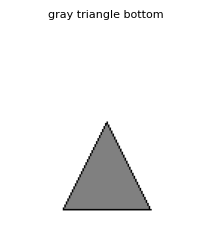

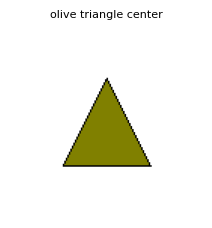

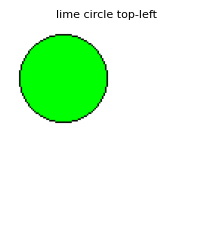

In [11]:
for _ in range(3):
    imgs, caps_tensor, caps = next(iter(train_loader))
    idx = random.randint(0, len(imgs) - 1)
    img = (imgs[idx].permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    caption_tokens = caps_tensor[idx].tolist()
    caption = " ".join([ds.vocab[token] for token in caption_tokens])
    # optional remove [CLS] token (but good for viz)

    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(img)
    plt.title(caps[idx], fontsize=8)
    plt.axis("off")
    plt.show()

In [12]:
class ImageEncoder(nn.Module):

    def __init__(self, embed_dim = EMBED_DIM):
        super().__init__()

        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(),
        )

        self.projection = nn.Linear(256, embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.convolutions(x)
        x = x.mean(dim=[2, 3])
        x = self.projection(x)
        x = F.normalize(self.layernorm1(x), dim=-1)
        return x


In [13]:
class TextEncoder(nn.Module):

    def __init__(self, embed_dim=EMBED_DIM, num_heads=ATTENTION_HEADS, vocab_size= vocab_size, context_window=4):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(context_window, embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads=num_heads, batch_first=True)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, toks):
        N, L = toks.shape
        pos_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)
        x = self.token_embedding(toks) + self.position_embedding(pos_ids)
        x = self.mha(x, x, x)[0]
        x = x[:, 0]
        x = self.projection(x)
        x = F.normalize(self.norm(x), dim=-1)
        return x

In [14]:
# #  text encoder without MHA

# class TextEncoder(nn.Module):

#     def __init__(self, embed_dim=EMBED_DIM, num_heads=ATTENTION_HEADS, vocab_size= vocab_size, context_window=4):
#         super().__init__()
#         self.token_embedding = nn.Embedding(vocab_size, embed_dim)
#         self.position_embedding = nn.Embedding(context_window, embed_dim)
#         self.projection = nn.Linear(embed_dim, embed_dim)
#         self.norm = nn.LayerNorm(embed_dim)

#     def forward(self, toks):
#         N, L = toks.shape
#         pos_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)
#         x = self.token_embedding(toks) + self.position_embedding(pos_ids)
#         x = self.projection(x)
#         x = F.normalize(self.norm(x), dim=-1)
#         return x

In [15]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
def clip_loss(img_emb, text_emb, temperature=TEMPERATURE):
    logits = img_emb @ text_emb.T / temperature
    targets = torch.arange(img_emb.size(0), device=img_emb.device)
    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.T, targets)
    return ((loss_i + loss_t) / 2.0)

In [17]:
img_encoder = ImageEncoder().to(device)
text_encoder = TextEncoder().to(device)

params = list(img_encoder.parameters()) + list(text_encoder.parameters())
optimizer = torch.optim.AdamW(params, lr=LR)

In [18]:
def show_image(t, title=None):
    img = (t.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    plt.figure(figsize=(2.2, 2.2))
    plt.axis("off")
    if title: plt.title(title, fontsize=8)
    plt.imshow(img); plt.show()

Sample Image and Caption for embeddings viz: 'pink square top'


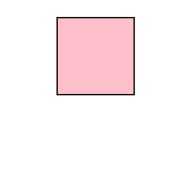

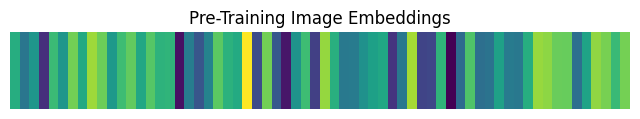

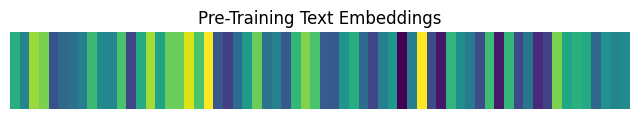

In [19]:
img_encoder.eval().to(device)
text_encoder.eval().to(device)

with torch.no_grad():
    random_idx = random.randrange(len(ds))
    sample_img, sample_toks, sample_cap = ds[random_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_toks = sample_toks.unsqueeze(0).to(device)
    pre_train_img_emb = img_encoder(sample_img).squeeze(0).cpu().numpy()
    pre_train_text_emb = text_encoder(sample_toks).squeeze(0).cpu().numpy()

print(f"Sample Image and Caption for embeddings viz: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

def plot_embedding(embedding, title):
    plt.figure(figsize = (8, 1))
    plt.imshow(embedding.reshape(1, -1), aspect="auto", cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_embedding(pre_train_img_emb, "Pre-Training Image Embeddings")
plot_embedding(pre_train_text_emb, "Pre-Training Text Embeddings")

In [20]:
img_encoder.to(device)
text_encoder.to(device)

best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    img_encoder.train()
    text_encoder.train()

    total = 0.0

    for imgs, toks, caps in train_loader:
        imgs = imgs.to(device)   # correct
        toks = toks.to(device)

        optimizer.zero_grad(set_to_none=True)

        ie = img_encoder(imgs)
        te = text_encoder(toks)

        loss = clip_loss(ie, te)
        loss.backward()
        optimizer.step()

        total += loss.item() * imgs.size(0)

    train_loss = total / len(train_loader.dataset)

    img_encoder.eval()
    text_encoder.eval()

    with torch.no_grad():
        vtotal, n = 0.0, 0
        for imgs, toks, _ in val_loader:
            imgs = imgs.to(device)
            toks = toks.to(device)

            vtotal += clip_loss(img_encoder(imgs), text_encoder(toks)).item() * imgs.size(0)
            n += imgs.size(0)

        val_loss = vtotal / n

    print(f"Epoch: {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
    best_val = min(best_val, val_loss)


Epoch: 01 | train 4.1539 | val 4.0064
Epoch: 02 | train 4.1182 | val 3.9852
Epoch: 03 | train 4.0774 | val 3.8791
Epoch: 04 | train 3.8522 | val 3.6081
Epoch: 05 | train 3.4772 | val 3.0515
Epoch: 06 | train 2.8445 | val 2.5237
Epoch: 07 | train 2.3323 | val 2.0769
Epoch: 08 | train 1.9609 | val 1.6781
Epoch: 09 | train 1.7077 | val 1.3951
Epoch: 10 | train 1.4826 | val 1.2361
Epoch: 11 | train 1.2462 | val 1.0419
Epoch: 12 | train 1.0540 | val 0.8750
Epoch: 13 | train 0.9226 | val 0.8598
Epoch: 14 | train 0.7948 | val 0.6992
Epoch: 15 | train 0.7506 | val 0.6997
Epoch: 16 | train 0.7038 | val 0.5832
Epoch: 17 | train 0.6449 | val 0.5966
Epoch: 18 | train 0.5879 | val 0.4375
Epoch: 19 | train 0.5214 | val 0.4999
Epoch: 20 | train 0.4475 | val 0.3469
Epoch: 21 | train 0.3440 | val 0.3030
Epoch: 22 | train 0.2923 | val 0.2758
Epoch: 23 | train 0.2737 | val 0.2615
Epoch: 24 | train 0.2343 | val 0.1635
Epoch: 25 | train 0.2145 | val 0.1598
Epoch: 26 | train 0.1784 | val 0.1537
Epoch: 27 | 

Sample Image and Caption for embeddings viz: 'pink square top'


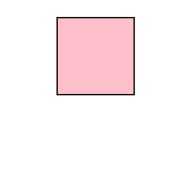

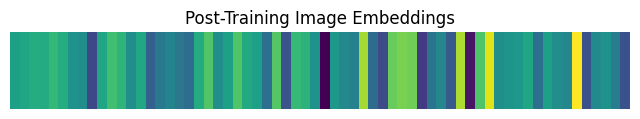

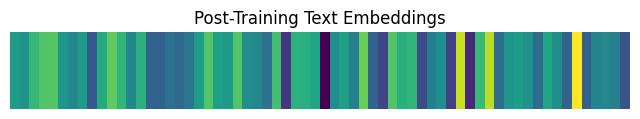

In [21]:
img_encoder.eval()
text_encoder.eval()

with torch.no_grad():
    sample_img, sample_toks, sample_cap = ds[random_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_toks = sample_toks.unsqueeze(0).to(device)

    post_train_img_emb = img_encoder(sample_img).squeeze(0).cpu().numpy()
    post_train_text_emb = text_encoder(sample_toks).squeeze(0).cpu().numpy()

print(f"Sample Image and Caption for embeddings viz: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

plot_embedding(post_train_img_emb, "Post-Training Image Embeddings")
plot_embedding(post_train_text_emb, "Post-Training Text Embeddings")

In [22]:
print("\nDot product between image and text embeddings:")
print(f"   Before training: {np.dot(pre_train_img_emb, pre_train_text_emb):.4f}")
print(f"   After training: {np.dot(post_train_img_emb, post_train_text_emb):.4f}")


Dot product between image and text embeddings:
   Before training: -0.2612
   After training: 0.9497


In [23]:
img_encoder.eval()
text_encoder.eval()

with torch.no_grad():
    val_imgs, val_toks, val_caps = [], [], []
    for imgs, toks, caps in val_loader:
        val_imgs.append(imgs)
        val_toks.append(toks)
        val_caps += list(caps)
    
    val_imgs = torch.cat(val_imgs).to(device)
    val_toks = torch.cat(val_toks).to(device)
    img_emb = img_encoder(val_imgs)
    text_emb = text_encoder(val_toks)

In [27]:
def topk_text_for_images(k=3, idxs=None):
    if idxs is None: idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (img_emb @ text_emb.t()).softmax(dim=1)
    print(f"Similarity Matrix shape: {sims.shape}")
    for i in idxs:
        print(f"Idx {i}")
        best = sims[i].topk(k).indices.tolist()
        print(f"Best Matrix: {best}")
        print(f"Best Matrix shape: {len(best)}")
        print(f"\nImage {i} best captions:")
        for j in best:
            print(" - ", val_caps[j])
        show_image(val_imgs[i].cpu())

def topk_images_for_text(k=3, idxs=None):
    if idxs is None: idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (text_emb @ img_emb.t()).softmax(dim=1)
    print(f"Similarity Matrix shape: {sims.shape}")
    for i in idxs:
        print(f"Idx {i}")
        best = sims[i].topk(k).indices.tolist()
        print(f"Best Matrix: {best}")
        print(f"Best Matrix shape: {len(best)}")
        print(f"\nText {i} best images:")
        for j in best:
            show_image(val_imgs[j].cpu(), title=f"match {val_caps[j]}")


Similarity Matrix shape: torch.Size([108, 108])
Idx 28
Best Matrix: [28, 30, 85]
Best Matrix shape: 3

Image 28 best captions:
 -  black square bottom
 -  gold square bottom
 -  navy square bottom


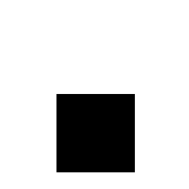

In [28]:
topk_text_for_images()

Similarity Matrix shape: torch.Size([108, 108])
Idx 93
Best Matrix: [93, 32, 21]
Best Matrix shape: 3

Text 93 best images:


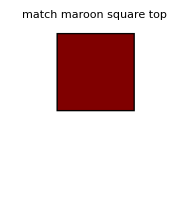

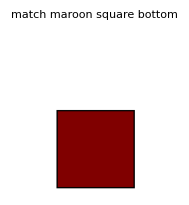

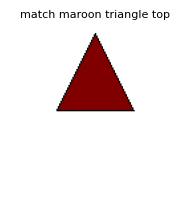

In [29]:
topk_images_for_text()